In [1]:
import glob
import random
import base64
import pandas as pd
import os
import math
import random
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from io import BytesIO
from IPython.display import HTML

In [2]:
def get_thumbnail(path):
    i = Image.open(path)
    i.thumbnail((150, 150), Image.LANCZOS)
    return i

def image_base64(im):
    if isinstance(im, str):
        im = get_thumbnail(im)
    with BytesIO() as buffer:
        im.convert('RGB').save(buffer, 'jpeg')
        return base64.b64encode(buffer.getvalue()).decode()
        
def image_formatter(im):
    return f'<img src="data:image/jpeg;base64,{image_base64(im)}">'

def image_list(folder):
    image_df = pd.DataFrame({'name':[], 'color model':[], 'format':[], 'channels':[],
        'size':[], 'width':[], 'height':[], 'full path':[], 'image':[]})
    
    files = glob.glob(folder)
    accept_files = ['.png', '.bmp', '.exif', '.gif', '.jpg', '.jpeg', '.png', '.jfif', '.tif', '.tiff']

    for file in files:
        if '.'+file.split('.')[-1] in accept_files:
            i = Image.open(file)
            size = os.path.getsize(file) / math.pow(2, 20)
            row = {'name':file.split('\\')[-1], 'color model':i.mode, 'format':i.format,
                   'channels':len(i.mode), 'size':"{val:.2f}".format(val = size),
                   'width':i.width, 'height':i.height,
                   'full path':file, 'image':get_thumbnail(file)}
            image_df = pd.concat([image_df, pd.DataFrame([row])], ignore_index=True)
    
    return image_df

,name,color model,format,channels,size,width,height,full path,image
0,003.png_res.jpg,RGB,JPEG,3.0,0.33,1600.0,1231.0,.\pictures\003.png_res.jpg,
1,020-021.png,P,PNG,1.0,1.48,2208.0,1600.0,.\pictures\020-021.png,
2,93.jpg,RGB,JPEG,3.0,0.10,1091.0,1279.0,.\pictures\93.jpg,
3,alucard.jpg,RGB,JPEG,3.0,0.05,246.0,655.0,.\pictures\alucard.jpg,
4,ded.jpg,RGB,JPEG,3.0,0.12,735.0,1112.0,.\pictures\ded.jpg,
5,driver down.jfif,RGB,JPEG,3.0,0.18,1200.0,675.0,.\pictures\driver down.jfif,
6,ed94.jpg,RGB,JPEG,3.0,0.08,474.0,945.0,.\pictures\ed94.jpg,
7,IMG_20220218_213148.jpg,RGB,JPEG,3.0,0.16,1080.0,803.0,.\pictures\IMG_20220218_213148.jpg,
8,sailor kaiman.jfif,RGB,JPEG,3.0,0.05,600.0,424.0,.\pictures\sailor kaiman.jfif,
9,solar.jpg,RGB,JPEG,3.0,0.03,474.0,632.0,.\pictures\solar.jpg,

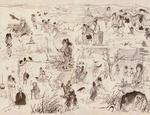
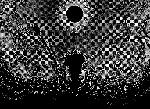
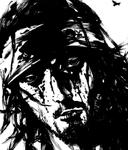
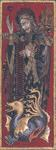
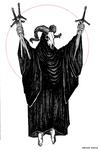
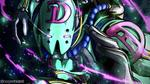
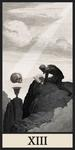
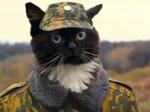
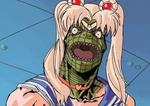
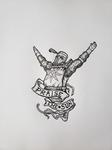
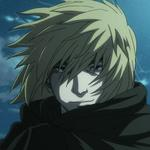
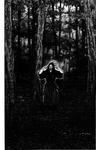
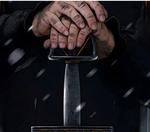
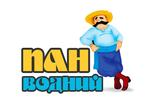
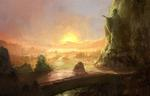

In [3]:
images = image_list('.\\pictures\\*')
HTML(images.to_html(formatters={'image': image_formatter}, escape=False))

In [4]:
def crop_im(pil_img, crop_w: int, crop_h: int):
    img_w, img_h = pil_img.size
    return pil_img.crop(((img_w - crop_w) / 2,
                         (img_h - crop_h) / 2,
                         (img_w + crop_w) / 2,
                         (img_h + crop_h) / 2))

def crop_and_resize(img_df: pd.DataFrame, ind: int, square_w: int):
    image = Image.open(img_df.iloc[ind]['full path'])
    dif = image.width - image.height
    if dif > 0:
        return crop_im(image, image.height, image.height).resize((square_w, square_w))
    if dif < 0:
        return crop_im(image, image.width, image.width).resize((square_w, square_w))
    
def set_color(image):
    if image.mode != 'RGB':
        image = image.convert('RGB')
    
    red, green, blue = image.split()
    zero = red.point(lambda x:0)

    colors_df = pd.DataFrame({
        'red':[red, zero, zero, red, zero, red],
        'green':[zero, green, zero, green, green, zero],
        'blue':[zero, zero, blue, zero, blue, blue]
    })
    
    return colors_df.iloc[random.randint(0, 5)]

def poster(folder, new_poster, col, row):
    poster_img = []
    for i in range(col * row + 1):
        pict_ind = random.choice(images.index)
        image = crop_and_resize(images, pict_ind, 200)
        color = set_color(image)
        image_to_plot = Image.merge('RGB',(color['red'], color['green'], color['blue']))
        poster_img.append(image_to_plot)

    first_img = poster_img[0]
    poster = Image.new(first_img.mode, ((first_img.width * col, first_img.height * row)))

    x = 0
    y = 0
    for img in poster_img[1:]:
        poster.paste(img, (x,y))
        if x + first_img.width == poster.width:
            x = 0
            y += first_img.height
        else:
            x += first_img.width

    poster.save(folder + new_poster + '.jpg', 'JPEG')
    return poster

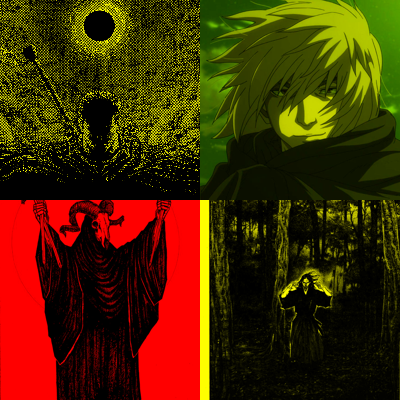

In [5]:
poster('./posters/', 'poster1', 2, 2)

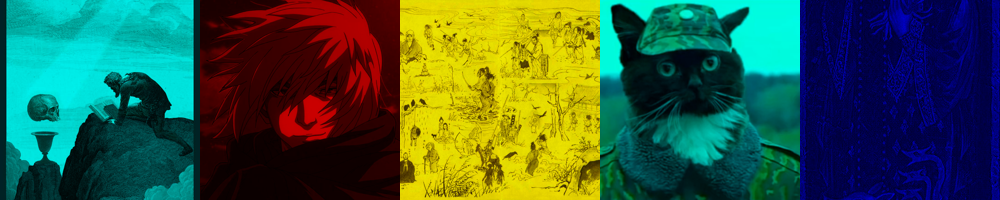

In [6]:
poster('./posters/', 'poster2', 5, 1)

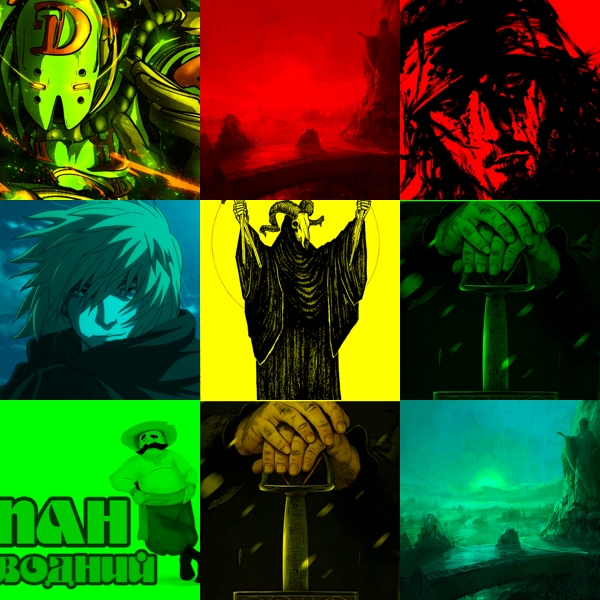

In [7]:
poster('./posters/', 'poster3', 3, 3)

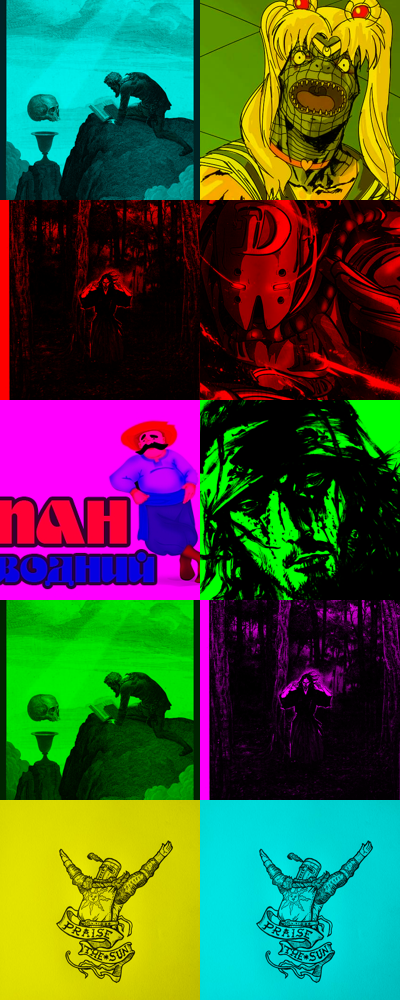

In [8]:
poster('./posters/', 'poster4', 2, 5)